In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
proc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

In [20]:
fulldata = pd.read_csv('/kaggle/input/diabetes/disease.csv')

In [21]:
fulldata = fulldata.drop('Unnamed: 133', axis=1)

In [22]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4962 entries, 0 to 4961
Columns: 133 entries, itching to prognosis
dtypes: int64(132), object(1)
memory usage: 5.0+ MB


In [23]:
fulldata['prognosis'].value_counts()
# Remove trailing white spaces only for "diabetes" and "hypertension" values
fulldata.loc[fulldata['prognosis'].isin(['Diabetes ', 'Hypertension ']), 'prognosis'] = fulldata['prognosis'].str.strip()

In [24]:
fulldata = fulldata.sample(frac=1).reset_index(drop=True)

In [25]:
train_datas = {}
mixed_data = pd.DataFrame()
old=[]
test_data = pd.DataFrame()
for i in fulldata['prognosis'].unique():
        print(i)
        old.append(i)
        train_datas[i] = fulldata[fulldata['prognosis'] == i][:60]
        mixed_data = pd.concat([mixed_data, fulldata[fulldata['prognosis'] == i][100:120]], axis=0)
        #test_data = pd.concat([test_data, fulldata[fulldata['prognosis'] == i][70:90]], axis=0)

Dimorphic hemmorhoids(piles)
Arthritis
Acne
Urinary tract infection
Peptic ulcer diseae
Gastroenteritis
Varicose veins
Hypothyroidism
Diabetes
Paralysis (brain hemorrhage)
hepatitis A
Dengue
Bronchial Asthma
Psoriasis
Heart attack
Drug Reaction
Hepatitis C
Hepatitis B
(vertigo) Paroymsal  Positional Vertigo
Hypoglycemia
Hypertension
Alcoholic hepatitis
Hyperthyroidism
Hepatitis D
GERD
Common Cold
Osteoarthristis
Cervical spondylosis
Migraine
Tuberculosis
Hepatitis E
AIDS
Jaundice
Fungal infection
Impetigo
Pneumonia
Malaria
Allergy
Chronic cholestasis
Typhoid
Chicken pox


In [26]:
test_data = mixed_data.copy()

In [27]:
new=[]
for i in fulldata['prognosis'].unique():
        new.append(i+"-1")
        train_datas[i+"-1"]=fulldata[fulldata['prognosis'] == i][60:100]


In [28]:
mixed_data = mixed_data.sample(frac=1).reset_index(drop=True)
mixed_data_labels = list(mixed_data['prognosis'])
mixed_data.drop(['prognosis'], axis=1, inplace=True)
mixed_data = mixed_data.to_numpy()

test_data = test_data.sample(frac=1).reset_index(drop=True)
test_data_labels = list(test_data['prognosis'])
test_data.drop(['prognosis'], axis=1, inplace=True)
test_data = test_data.to_numpy()

for i in train_datas:
    train_datas[i].drop(['prognosis'], axis=1, inplace=True)
    train_datas[i] = train_datas[i].sample(frac=1).reset_index(drop=True)
    train_datas[i] = train_datas[i].to_numpy()

In [29]:
train_loader = {}
devices = []
batch_size=16
for i in train_datas:
    train_loader[i] = DataLoader(train_datas[i],batch_size=batch_size, shuffle=True)
    devices.append(i)

In [30]:
for label in train_datas.keys():
    print(label,len(train_datas[label]),train_datas[label].shape)

Dimorphic hemmorhoids(piles) 60 (60, 132)
Arthritis 60 (60, 132)
Acne 60 (60, 132)
Urinary tract infection 60 (60, 132)
Peptic ulcer diseae 60 (60, 132)
Gastroenteritis 60 (60, 132)
Varicose veins 60 (60, 132)
Hypothyroidism 60 (60, 132)
Diabetes 60 (60, 132)
Paralysis (brain hemorrhage) 60 (60, 132)
hepatitis A 60 (60, 132)
Dengue 60 (60, 132)
Bronchial Asthma 60 (60, 132)
Psoriasis 60 (60, 132)
Heart attack 60 (60, 132)
Drug Reaction 60 (60, 132)
Hepatitis C 60 (60, 132)
Hepatitis B 60 (60, 132)
(vertigo) Paroymsal  Positional Vertigo 60 (60, 132)
Hypoglycemia 60 (60, 132)
Hypertension 60 (60, 132)
Alcoholic hepatitis 60 (60, 132)
Hyperthyroidism 60 (60, 132)
Hepatitis D 60 (60, 132)
GERD 60 (60, 132)
Common Cold 60 (60, 132)
Osteoarthristis 60 (60, 132)
Cervical spondylosis 60 (60, 132)
Migraine 60 (60, 132)
Tuberculosis 60 (60, 132)
Hepatitis E 60 (60, 132)
AIDS 60 (60, 132)
Jaundice 60 (60, 132)
Fungal infection 60 (60, 132)
Impetigo 60 (60, 132)
Pneumonia 60 (60, 132)
Malaria 60 

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

input_dim = train_loader['Arthritis'].dataset.shape[1]

# Define AEModel with regularization
class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 120)  
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 15)
        self.fc6 = nn.Linear(15, 15)
        self.fc7 = nn.Linear(15, 30)
        self.fc8 = nn.Linear(30, 60)
        self.fc9 = nn.Linear(60, 120)
        self.fc10 = nn.Linear(120, input_dim)
        self.fc11 = nn.Linear(input_dim, input_dim) 
        self.activation = nn.Tanh()
        #self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.5
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        #x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        #x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc7(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc8(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc9(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc10(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc11(x)
        return x

In [32]:
# Function for client update with regularization
def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    criterion = nn.MSELoss(reduction='mean')
    for e in range(epoch):
        running_loss = 0.0
        for data in train_data:
            output = client_model(data.float())
            optimizer.zero_grad()
            loss = criterion(data.float().to(proc), output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_data)
    return epoch_loss

In [33]:
client_models = {i: AEModel(input_dim).to(proc) for i in devices}
opt = {i: optim.SGD(client_models[i].parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5) for i in devices}

In [34]:

num_clients = len(train_loader)      
num_selected = len(train_loader)    

num_rounds = 1 
epochs = 150

In [35]:
# Train Client Model and Global Model
start_time = time.time()
for r in range(num_rounds):  # total number of rounds
    print('\nround: ', r+1)
    loss = 0
    for i in devices:
        l = client_update(client_models[i], opt[i], train_loader[i], epochs)
        print('client: ', i, 'loss: ', l)
        loss += l
time_required = time.time() - start_time
print('/nTIME: {}mins'.format(time_required/60))


round:  1
client:  Dimorphic hemmorhoids(piles) loss:  0.0016759760267935537
client:  Arthritis loss:  0.0016200101402015813
client:  Acne loss:  0.00232151678186104
client:  Urinary tract infection loss:  0.002204774439451285
client:  Peptic ulcer diseae loss:  0.002960686279160048
client:  Gastroenteritis loss:  0.0018379291856642037
client:  Varicose veins loss:  0.0029693777641417304
client:  Hypothyroidism loss:  0.002307366979099849
client:  Diabetes loss:  0.0029354706620021414
client:  Paralysis (brain hemorrhage) loss:  0.0021418269199784843
client:  hepatitis A loss:  0.003073559674764207
client:  Dengue loss:  0.003317034501136125
client:  Bronchial Asthma loss:  0.002424777920532506
client:  Psoriasis loss:  0.002780315635027364
client:  Heart attack loss:  0.0023620545257775423
client:  Drug Reaction loss:  0.002368596646313866
client:  Hepatitis C loss:  0.0025716873754087527
client:  Hepatitis B loss:  0.003076917856378714
client:  (vertigo) Paroymsal  Positional Vertig

In [40]:
import os
try:
    os.makedirs('/kaggle/working/diseases/')
except:
    pass
for i in devices:
    torch.save(client_models[i],'/kaggle/working/diseases/' + i + '.pt')

In [ ]:
client_models = {}
for device in devices:
    client_models[device] = torch.load('/kaggle/input/dieseases/keras/extra_clients/1/diseases/' + device + '.pt')

In [36]:
def quan_thresh(model, dataloader, quantile=0.9):
    model.eval()
    se = []
    for batch in dataloader:
        for data in batch:
            error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2) # len(error) = 66
            se.append(sum(error))
    return np.mean(se) + np.std(se), np.quantile(se, quantile), se 

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
            TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
            FP += 1
        if y_actual[i] == y_pred[i] == 0:
            TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
            FN += 1
    return (TP, FP, TN, FN)

In [37]:
thresholds = {}
quans = {}
errors = {}
for device in devices:
    model = client_models[device]
    dataloader = train_loader[device]
    thresholds[device], quans[device], errors[device] = quan_thresh(model, dataloader)
print(thresholds)

{'Dimorphic hemmorhoids(piles)': 0.5841768752535266, 'Arthritis': 0.5848276990033251, 'Acne': 0.6690747742094159, 'Urinary tract infection': 0.6451633648806685, 'Peptic ulcer diseae': 0.7898282107316672, 'Gastroenteritis': 0.5892789661115518, 'Varicose veins': 0.8108125744904856, 'Hypothyroidism': 0.7110941171320169, 'Diabetes': 0.8194627390350193, 'Paralysis (brain hemorrhage)': 0.6536432831569836, 'hepatitis A': 0.8297083425487397, 'Dengue': 0.8755532331181528, 'Bronchial Asthma': 0.7137289416747028, 'Psoriasis': 0.7713878793855993, 'Heart attack': 0.6527674116965831, 'Drug Reaction': 0.6794242024811186, 'Hepatitis C': 0.7431312508610883, 'Hepatitis B': 0.8274426070855039, '(vertigo) Paroymsal  Positional Vertigo': 0.7225167551928204, 'Hypoglycemia': 0.6977979597070991, 'Hypertension': 0.7362761834916453, 'Alcoholic hepatitis': 0.679983038095707, 'Hyperthyroidism': 0.8237095271224399, 'Hepatitis D': 0.8628670504356148, 'GERD': 0.7761144869114507, 'Common Cold': 0.8484833067737025, 'O

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata, pearsonr
from sklearn.metrics import mutual_info_score
selectedattackbenmix_stats = []
res=[]
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
    model = client_models[device]
    model.eval()
    labels = mixed_data_labels
    threshold = thresholds[device]
    temp=[]
    y_true = []
    y_pred = []
    ind = 0
    for data in mixed_data:
        data = torch.Tensor(data)
        error = np.sum(np.power(data.detach().numpy() - model(data).detach().numpy(), 2))
        temp.append(error)
        if device[:-2]== labels[ind]:
            y_true.append(1)
            y_pred.append(1 if error < threshold else 0)
        else:
            y_true.append(0)
            y_pred.append(0 if error >= threshold else 1)
        ind += 1
    res.append([device,min(temp),max(temp)])
    TP, FP, TN, FN = perf_measure(y_true, y_pred)
    TP += 1
    FN += 1
    TN += 1
    FP += 1
    conf_matrix = [[TP, FN], [FP, TN]]
    plt.figure() 
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion Matrix for Client " + str(device) +" with mixed data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))
    TPR = round((TP / (TP+FN)), 6)
    FPR = round((FP / (FP + TN)), 6)
    selectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with mixed data"),acc*100,precision,recall,F1score*100,TPR,FPR])

  #   [['TP', 'FN']
  #   ['FP', 'TN']]

In [ ]:
for i in selectedattackbenmix_stats:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

input_dim = train_loader['Arthritis'].dataset.shape[1]

# Define AEModel with regularization
class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 120)  
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 15)
        self.fc6 = nn.Linear(15, 15)
        self.fc7 = nn.Linear(15, 30)
        self.fc8 = nn.Linear(30, 60)
        self.fc9 = nn.Linear(60, 120)
        self.fc10 = nn.Linear(120, input_dim)
        self.fc11 = nn.Linear(input_dim, input_dim) 
        self.activation = nn.Tanh()
        #self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.5
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        #x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        #x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc7(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc8(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc9(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc10(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc11(x)
        return x

In [43]:
client_models = {}
for device in devices:
    client_models[device] = torch.load('/kaggle/input/dieseases/keras/extra_clients/4/diseases/' + device + '.pt')

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

input_dim = train_loader['Arthritis'].dataset.shape[1]

# Define AEModel with regularization
class AEModelEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AEModelEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 120)  
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 15)
        self.fc6 = nn.Linear(15, 15)
        self.activation = nn.Tanh()
        #self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.5
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        #x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        #x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        return x
    
    
# Function to load encoder weights from the full model
def load_encoder_weights(full_model, encoder_model):
    encoder_model.fc1.weight.data = full_model.fc1.weight.data
    encoder_model.fc1.bias.data = full_model.fc1.bias.data
    encoder_model.fc2.weight.data = full_model.fc2.weight.data
    encoder_model.fc2.bias.data = full_model.fc2.bias.data
    encoder_model.fc3.weight.data = full_model.fc3.weight.data
    encoder_model.fc3.bias.data = full_model.fc3.bias.data
    encoder_model.fc4.weight.data = full_model.fc4.weight.data
    encoder_model.fc4.bias.data = full_model.fc4.bias.data
    encoder_model.fc5.weight.data = full_model.fc5.weight.data
    encoder_model.fc5.bias.data = full_model.fc5.bias.data
    encoder_model.fc6.weight.data = full_model.fc6.weight.data
    encoder_model.fc6.bias.data = full_model.fc6.bias.data
# Update client_models to use the encoder-only model
client_models_encoders = {}
for device in devices:
    full_model = torch.load('/kaggle/input/dieseases/keras/extra_clients/4/diseases/' + device + '.pt')
    encoder_model = AEModelEncoder(input_dim)
    load_encoder_weights(full_model, encoder_model)
    client_models_encoders[device] = encoder_model

In [46]:
agg_models={}
client_lens={}
agg_models_labels={}
for i in client_models_encoders.keys():
    if i[:-2] in client_models_encoders.keys():
        try:
            agg_models[i[:-2]].append(client_models_encoders[i])
            agg_models_labels[i[:-2]].append(i)
            client_lens[i[:-2]].append(len(train_datas[i]))
            print(i)
        except:
            print(i)
            agg_models[i[:-2]]=[client_models_encoders[i[:-2]],client_models_encoders[i]]
            agg_models_labels[i[:-2]]=[i[:-2],i]
            client_lens[i[:-2]]=[len(train_datas[i[:-2]]),len(train_datas[i])]
            

Dimorphic hemmorhoids(piles)-1
Arthritis-1
Acne-1
Urinary tract infection-1
Peptic ulcer diseae-1
Gastroenteritis-1
Varicose veins-1
Hypothyroidism-1
Diabetes-1
Paralysis (brain hemorrhage)-1
hepatitis A-1
Dengue-1
Bronchial Asthma-1
Psoriasis-1
Heart attack-1
Drug Reaction-1
Hepatitis C-1
Hepatitis B-1
(vertigo) Paroymsal  Positional Vertigo-1
Hypoglycemia-1
Hypertension-1
Alcoholic hepatitis-1
Hyperthyroidism-1
Hepatitis D-1
GERD-1
Common Cold-1
Osteoarthristis-1
Cervical spondylosis-1
Migraine-1
Tuberculosis-1
Hepatitis E-1
AIDS-1
Jaundice-1
Fungal infection-1
Impetigo-1
Pneumonia-1
Malaria-1
Allergy-1
Chronic cholestasis-1
Typhoid-1
Chicken pox-1


In [47]:
def server_aggregate_fedprox(global_model, client_models, mu=0.05):
    n = len(client_models)
    global_dict = global_model.state_dict()
    
    for k in global_dict.keys():
        # Calculate the average of the client model parameters
        global_weight = sum(client_models[i].state_dict()[k].float() for i in range(n)) / n
        
        # Apply the FedProx proximal term
        prox_term = mu * global_dict[k]
        global_dict[k] = (global_weight + prox_term) / (1 + mu)
    
    # Load the updated parameters into the global model
    global_model.load_state_dict(global_dict)
    
    # Update each client model with the new global parameters
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [48]:
opt = {i: optim.SGD(client_models[i].parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5) for i in devices}

In [50]:
epochs=2
trained=[]
for r in range(5):
    print('\nround: ', r+1)
    for i in agg_models.keys():
        server_aggregate_fedprox(client_models_encoders[i],agg_models[i])
        for k in agg_models[i]:
            for j in client_models_encoders.keys():
                if agg_models_labels[i][agg_models[i].index(k)] == j:
                    load_encoder_weights(client_models_encoders[j],client_models[j])
    for j in client_models.keys():
        if j[:-2] in client_models.keys():
            if j[:-2] not in trained:
                loss = 0
                l = client_update(client_models[j[:-2]], opt[j[:-2]], train_loader[j[:-2]], epochs)
                print('client: ', j[:-2], 'loss: ', l)
                loss += l
                trained.append(j[:-2])
            loss = 0
            l = client_update(client_models[j], opt[j], train_loader[j], epochs)
            print('client: ', j, 'loss: ', l)
            loss += l
    trained=[]
    for i in agg_models.keys():
        for k in agg_models[i]:
            for j in client_models.keys():
                if agg_models_labels[i][agg_models[i].index(k)] == j:
                    load_encoder_weights(client_models[j],k)
        

for i in agg_models.keys():
    server_aggregate_fedprox(client_models_encoders[i],agg_models[i])
    for k in agg_models[i]:
        for j in client_models_encoders.keys():
            if agg_models_labels[i][agg_models[i].index(k)] == j:
                load_encoder_weights(client_models_encoders[j],client_models[j])


round:  1
client:  Dimorphic hemmorhoids(piles) loss:  0.0020692279057887694
client:  Dimorphic hemmorhoids(piles)-1 loss:  0.0025133570932666773
client:  Arthritis loss:  0.0018253739346012785
client:  Arthritis-1 loss:  0.002134818806371186
client:  Acne loss:  0.002693912231673797
client:  Acne-1 loss:  0.0030489256751025096
client:  Urinary tract infection loss:  0.0025356191899239397
client:  Urinary tract infection-1 loss:  0.0030820773128652943
client:  Peptic ulcer diseae loss:  0.0032471370805675784
client:  Peptic ulcer diseae-1 loss:  0.003213401883840561
client:  Gastroenteritis loss:  0.002286788558315796
client:  Gastroenteritis-1 loss:  0.0026182122237514704
client:  Varicose veins loss:  0.0032360588753363117
client:  Varicose veins-1 loss:  0.003974782861769199
client:  Hypothyroidism loss:  0.0025697031916934064
client:  Hypothyroidism-1 loss:  0.004024871665751562
client:  Diabetes loss:  0.003133082402443203
client:  Diabetes-1 loss:  0.002919618645682931
client:  

In [51]:
import os
try:
    os.makedirs('/kaggle/working/models_extra/clients/')
except:
    pass
for i in devices:
    torch.save(client_models[i],'/kaggle/working/models_extra/clients/' + i + '.pt')

## Global model creation (K-means)

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

input_dim = train_loader['Arthritis'].dataset.shape[1]

# Define AEModel with regularization
class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 120)  
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 15)
        self.fc6 = nn.Linear(15, 15)
        self.fc7 = nn.Linear(15, 30)
        self.fc8 = nn.Linear(30, 60)
        self.fc9 = nn.Linear(60, 120)
        self.fc10 = nn.Linear(120, input_dim)
        self.fc11 = nn.Linear(input_dim, input_dim) 
        self.activation = nn.Tanh()
        #self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.5
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        #x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        #x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc7(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc8(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc9(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc10(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc11(x)
        return x

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

input_dim = train_loader['Arthritis'].dataset.shape[1]

# Define AEModel with regularization
class AEModelEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AEModelEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 120)  
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 15)
        self.fc6 = nn.Linear(15, 15)
        self.activation = nn.Tanh()
        #self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.5
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        #x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        #x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        return x
    
    
# Function to load encoder weights from the full model
def load_encoder_weights(full_model, encoder_model):
    encoder_model.fc1.weight.data = full_model.fc1.weight.data
    encoder_model.fc1.bias.data = full_model.fc1.bias.data
    encoder_model.fc2.weight.data = full_model.fc2.weight.data
    encoder_model.fc2.bias.data = full_model.fc2.bias.data
    encoder_model.fc3.weight.data = full_model.fc3.weight.data
    encoder_model.fc3.bias.data = full_model.fc3.bias.data
    encoder_model.fc4.weight.data = full_model.fc4.weight.data
    encoder_model.fc4.bias.data = full_model.fc4.bias.data
    encoder_model.fc5.weight.data = full_model.fc5.weight.data
    encoder_model.fc5.bias.data = full_model.fc5.bias.data
    encoder_model.fc6.weight.data = full_model.fc6.weight.data
    encoder_model.fc6.bias.data = full_model.fc6.bias.data
# Update client_models to use the encoder-only model
client_models = {}
for device in old:
    full_model = torch.load('/kaggle/input/dieseases/keras/extra_clients/4/diseases/' + device + '.pt')
    encoder_model = AEModelEncoder(input_dim)
    load_encoder_weights(full_model, encoder_model)
    client_models[device] = encoder_model
client_models.keys()

dict_keys(['Dimorphic hemmorhoids(piles)', 'Arthritis', 'Acne', 'Urinary tract infection', 'Peptic ulcer diseae', 'Gastroenteritis', 'Varicose veins', 'Hypothyroidism', 'Diabetes', 'Paralysis (brain hemorrhage)', 'hepatitis A', 'Dengue', 'Bronchial Asthma', 'Psoriasis', 'Heart attack', 'Drug Reaction', 'Hepatitis C', 'Hepatitis B', '(vertigo) Paroymsal  Positional Vertigo', 'Hypoglycemia', 'Hypertension', 'Alcoholic hepatitis', 'Hyperthyroidism', 'Hepatitis D', 'GERD', 'Common Cold', 'Osteoarthristis', 'Cervical spondylosis', 'Migraine', 'Tuberculosis', 'Hepatitis E', 'AIDS', 'Jaundice', 'Fungal infection', 'Impetigo', 'Pneumonia', 'Malaria', 'Allergy', 'Chronic cholestasis', 'Typhoid', 'Chicken pox'])

In [55]:
compressed_outs = {}
compressed_outs_test = {}
for i in client_models:
    model = client_models[i]
    dataloader = train_loader[i]
    outs = []
    ind = 0
    flag = False
    for batch in dataloader:
        for data in batch:
            layer_output = model(data.float()).detach().numpy()
            outs.append(layer_output)
            ind += 1
            if ind == 60:
                compressed_outs[i] = outs
                outs = []
            elif ind == 70:
                compressed_outs_test[i] = outs
                flag = True
                break
        if flag:
            break

In [56]:
for i in compressed_outs:
    if i[:-2] in compressed_outs:
        for j in compressed_outs[i]:
            compressed_outs[i[:-2]].append(j)

In [57]:
l=[]
for i in compressed_outs:
    if i[-2]=="-":
        l.append(i)
for i in l:
    compressed_outs.pop(i)

In [58]:
for i in compressed_outs.keys():
    print(i,': ',len(compressed_outs[i]))


Dimorphic hemmorhoids(piles) :  60
Arthritis :  60
Acne :  60
Urinary tract infection :  60
Peptic ulcer diseae :  60
Gastroenteritis :  60
Varicose veins :  60
Hypothyroidism :  60
Diabetes :  60
Paralysis (brain hemorrhage) :  60
hepatitis A :  60
Dengue :  60
Bronchial Asthma :  60
Psoriasis :  60
Heart attack :  60
Drug Reaction :  60
Hepatitis C :  60
Hepatitis B :  60
(vertigo) Paroymsal  Positional Vertigo :  60
Hypoglycemia :  60
Hypertension :  60
Alcoholic hepatitis :  60
Hyperthyroidism :  60
Hepatitis D :  60
GERD :  60
Common Cold :  60
Osteoarthristis :  60
Cervical spondylosis :  60
Migraine :  60
Tuberculosis :  60
Hepatitis E :  60
AIDS :  60
Jaundice :  60
Fungal infection :  60
Impetigo :  60
Pneumonia :  60
Malaria :  60
Allergy :  60
Chronic cholestasis :  60
Typhoid :  60
Chicken pox :  60


In [59]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np

# Extract data from the dictionary
data = []
labels = []

for label, tensors in compressed_outs.items():
    for tensor in tensors:
        data.append(tensor)
        labels.append(label)

data = np.array(data)
labels = np.array(labels)

# Get the number of samples
num_samples = len(data)

# Generate a random permutation of indices
permutation_indices = np.random.permutation(num_samples)

# Shuffle data and labels arrays using the permutation
shuffled_data = data[permutation_indices]
shuffled_labels = labels[permutation_indices]
data=shuffled_data
labels=shuffled_labels

In [60]:
n=42
# Apply KMeans clustering
kmeans = KMeans(n_clusters=n, random_state=100)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


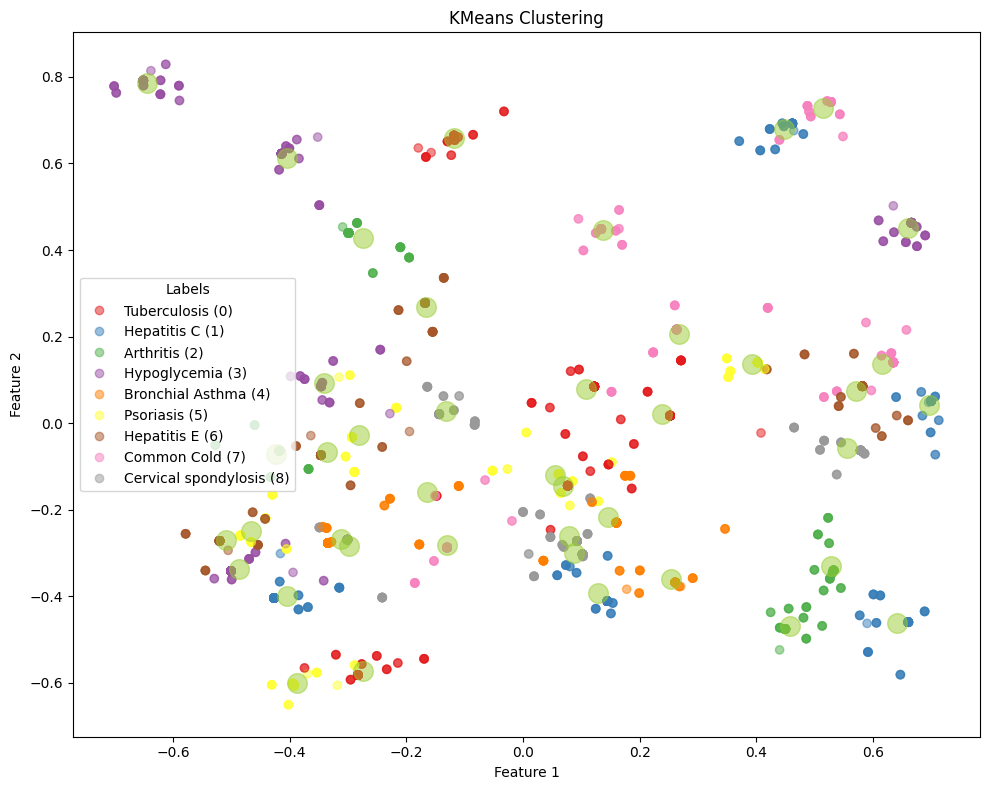

In [61]:
cluster_labels = kmeans.fit_predict(data)

# Get the cluster centroids
centroids = kmeans.cluster_centers_

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 8))

# Visualize the clusters with different colors for each label
scatter = ax.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='Set1', alpha=0.5)

# Plot the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='yellowgreen', s=200, alpha=0.5)

# Add legend with label names only if there are valid elements
if scatter.legend_elements()[0] is not None and len(scatter.legend_elements()[0]) > 0:
    unique_labels = list(set(labels))
    legend_labels = [f'{label} ({i})' for i, label in enumerate(unique_labels)]
    ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Labels')

ax.set_title('KMeans Clustering')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

plt.tight_layout()

plt.show()

In [62]:
# Dictionary to store attacks and their counts for each cluster
cluster_attacks_count = {cluster: {} for cluster in range(n)}

# Iterate through data and cluster labels
for idx, cluster_label in enumerate(cluster_labels):
    attack = labels[idx]
    if attack not in cluster_attacks_count[cluster_label]:
        cluster_attacks_count[cluster_label][attack] = 1
        
    else:
        cluster_attacks_count[cluster_label][attack] += 1
    
# Print attacks and their counts for each cluster
for cluster, attack_counts in cluster_attacks_count.items():
    print(f"Cluster {cluster}: {attack_counts}")

Cluster 0: {'Arthritis': 60}
Cluster 1: {'Cervical spondylosis': 60, 'Fungal infection': 1}
Cluster 2: {'Impetigo': 60}
Cluster 3: {'Typhoid': 60}
Cluster 4: {'Chicken pox': 60}
Cluster 5: {'Hepatitis B': 60}
Cluster 6: {'(vertigo) Paroymsal  Positional Vertigo': 60}
Cluster 7: {'Hypoglycemia': 60}
Cluster 8: {'Common Cold': 60}
Cluster 9: {'Hyperthyroidism': 60}
Cluster 10: {'hepatitis A': 60}
Cluster 11: {'Drug Reaction': 60}
Cluster 12: {'Paralysis (brain hemorrhage)': 60}
Cluster 13: {'Hepatitis E': 60}
Cluster 14: {'Diabetes': 60}
Cluster 15: {'Alcoholic hepatitis': 60}
Cluster 16: {'Dengue': 60}
Cluster 17: {'Migraine': 60}
Cluster 18: {'Hypothyroidism': 60}
Cluster 19: {'Allergy': 11}
Cluster 20: {'Acne': 60}
Cluster 21: {'Jaundice': 60}
Cluster 22: {'Bronchial Asthma': 60}
Cluster 23: {'AIDS': 60}
Cluster 24: {'Heart attack': 60}
Cluster 25: {'Tuberculosis': 60}
Cluster 26: {'Pneumonia': 60}
Cluster 27: {'Hypertension': 60}
Cluster 28: {'Hepatitis D': 60}
Cluster 29: {'Hepatiti

In [63]:
cluster_labels = {}
for i in range(n):
    cluster_labels[i] = max(cluster_attacks_count[i], key=cluster_attacks_count[i].get)
cluster_labels

{0: 'Arthritis',
 1: 'Cervical spondylosis',
 2: 'Impetigo',
 3: 'Typhoid',
 4: 'Chicken pox',
 5: 'Hepatitis B',
 6: '(vertigo) Paroymsal  Positional Vertigo',
 7: 'Hypoglycemia',
 8: 'Common Cold',
 9: 'Hyperthyroidism',
 10: 'hepatitis A',
 11: 'Drug Reaction',
 12: 'Paralysis (brain hemorrhage)',
 13: 'Hepatitis E',
 14: 'Diabetes',
 15: 'Alcoholic hepatitis',
 16: 'Dengue',
 17: 'Migraine',
 18: 'Hypothyroidism',
 19: 'Allergy',
 20: 'Acne',
 21: 'Jaundice',
 22: 'Bronchial Asthma',
 23: 'AIDS',
 24: 'Heart attack',
 25: 'Tuberculosis',
 26: 'Pneumonia',
 27: 'Hypertension',
 28: 'Hepatitis D',
 29: 'Hepatitis C',
 30: 'Urinary tract infection',
 31: 'Osteoarthristis',
 32: 'Malaria',
 33: 'Dimorphic hemmorhoids(piles)',
 34: 'Varicose veins',
 35: 'Chronic cholestasis',
 36: 'Fungal infection',
 37: 'Psoriasis',
 38: 'Gastroenteritis',
 39: 'Peptic ulcer diseae',
 40: 'GERD',
 41: 'Allergy'}

In [64]:
cluster_labels={0: 'Arthritis',
 1: 'Cervical spondylosis',
 2: 'Impetigo',
 3: 'Typhoid',
 4: 'Chicken pox',
 5: 'Hepatitis B',
 6: '(vertigo) Paroymsal  Positional Vertigo',
 7: 'Hypoglycemia',
 8: 'Common Cold',
 9: 'Hyperthyroidism',
 10: 'hepatitis A',
 11: 'Drug Reaction',
 12: 'Paralysis (brain hemorrhage)',
 13: 'Hepatitis E',
 14: 'Diabetes',
 15: 'Alcoholic hepatitis',
 16: 'Dengue',
 17: 'Migraine',
 18: 'Hypothyroidism',
 19: 'Allergy',
 20: 'Acne',
 21: 'Jaundice',
 22: 'Bronchial Asthma',
 23: 'AIDS',
 24: 'Heart attack',
 25: 'Tuberculosis',
 26: 'Pneumonia',
 27: 'Hypertension',
 28: 'Hepatitis D',
 29: 'Hepatitis C',
 30: 'Urinary tract infection',
 31: 'Osteoarthristis',
 32: 'Malaria',
 33: 'Dimorphic hemmorhoids(piles)',
 34: 'Varicose veins',
 35: 'Chronic cholestasis',
 36: 'Fungal infection',
 37: 'Psoriasis',
 38: 'Gastroenteritis',
 39: 'Peptic ulcer diseae',
 40: 'GERD',
 41: 'Allergy'}

In [65]:
l=[]
for i in client_models.keys():
    if i[-2]=="-":
        l.append(i)
for i in l:
    client_models.pop(i)

In [66]:
compressed_mixed = {}
for data in mixed_data:
    for i in client_models:
        model = client_models[i]
        model.eval()
        layer_output = model(torch.Tensor(data))
        try:
            compressed_mixed[i].append(layer_output)
        except:
            compressed_mixed[i] = [layer_output]

In [105]:
old_thresholds={'Dimorphic hemmorhoids(piles)': 0.6117194899020568, 'Arthritis': 0.5969229933911957, 'Acne': 0.7133145762741151, 'Urinary tract infection': 0.6933170622666082, 'Peptic ulcer diseae': 0.8234049010448341, 'Gastroenteritis': 0.6572505448020081, 'Varicose veins': 0.8446527629629852, 'Hypothyroidism': 0.7353899827506669, 'Diabetes': 0.8231439117771955, 'Paralysis (brain hemorrhage)': 0.6768870014685169, 'hepatitis A': 0.8703375991100754, 'Dengue': 0.8832884791443012, 'Bronchial Asthma': 0.7355895509889299, 'Psoriasis': 0.8171297846757992, 'Heart attack': 0.7423651144019883, 'Drug Reaction': 0.7326144624306357, 'Hepatitis B': 0.8549008952792847, '(vertigo) Paroymsal  Positional Vertigo': 0.7418122939795293, 'Hypoglycemia': 0.7060946051565444, 'Hypertension': 0.764645885400518, 'Alcoholic hepatitis': 0.6914826751588237, 'Hyperthyroidism': 0.8315188906459553, 'Hepatitis D': 0.8817590330482903, 'GERD': 0.8164914602674243, 'Common Cold': 0.8498306591476235, 'Osteoarthristis': 0.6264064437242532, 'Cervical spondylosis': 0.725088679641686, 'Migraine': 0.8850166359771628, 'Tuberculosis': 0.804770369011979, 'Hepatitis E': 0.8129534813469685, 'AIDS': 0.7051510789532651, 'Jaundice': 0.7633884076956257, 'Fungal infection': 1.1981919281065498, 'Impetigo': 0.598583744421995, 'Pneumonia': 0.8581022297113401, 'Malaria': 0.7302196435806084, 'Allergy': 0.7469445075871105, 'Chronic cholestasis': 0.7790242302542838, 'Typhoid': 0.797881173462851, 'Chicken pox': 0.8334967252664576, 'Dimorphic hemmorhoids(piles)-1': 0.6510325614283506, 'Arthritis-1': 0.5781351553211584, 'Acne-1': 0.6656051485800617, 'Urinary tract infection-1': 0.7360904891565911, 'Peptic ulcer diseae-1': 0.7271677970368058, 'Gastroenteritis-1': 0.7139917249278216, 'Varicose veins-1': 0.784694142208817, 'Hypothyroidism-1': 0.8579483221040047, 'Diabetes-1': 0.7333515244925148, 'Paralysis (brain hemorrhage)-1': 0.7221287850090565, 'hepatitis A-1': 0.6930924847220721, 'Dengue-1': 0.7885743161738017, 'Bronchial Asthma-1': 0.8362977034803358, 'Psoriasis-1': 0.5639561558540741, 'Heart attack-1': 0.6508967533878915, 'Drug Reaction-1': 0.7936452081436258, 'Hepatitis B-1': 0.7770528350914939, '(vertigo) Paroymsal  Positional Vertigo-1': 0.7455912903521045, 'Hypoglycemia-1': 0.9302744492253603, 'Hypertension-1': 0.7057060364064922, 'Alcoholic hepatitis-1': 0.7723656057664885, 'Hyperthyroidism-1': 0.7898015718559016, 'Hepatitis D-1': 0.8773411433903099, 'GERD-1': 0.7792601475404235, 'Common Cold-1': 0.7355320091635194, 'Osteoarthristis-1': 0.734891979227007, 'Cervical spondylosis-1': 0.6623029207594235, 'Migraine-1': 0.8999691165238815, 'Tuberculosis-1': 0.7856065304188338, 'Hepatitis E-1': 0.8259127857815708, 'AIDS-1': 0.6521788088030066, 'Jaundice-1': 0.8210379723674175, 'Fungal infection-1': 0.6167226686622422, 'Impetigo-1': 0.7852205643083361, 'Pneumonia-1': 0.687342828820945, 'Malaria-1': 0.8149112692789591, 'Allergy-1': 0.6963640755871716, 'Chronic cholestasis-1': 0.6440039795213612, 'Typhoid-1': 0.7903539879228333, 'Chicken pox-1': 0.791733449086027}

In [441]:
old_thresholds={'Dimorphic hemmorhoids(piles)': 0.5835243562683696, 'Arthritis': 0.5851630617858171, 'Acne': 0.6719620038685246, 'Urinary tract infection': 0.6453163173608591, 'Peptic ulcer diseae': 0.7891340218165371, 'Gastroenteritis': 0.5884205266763828, 'Varicose veins': 0.8104306765021057, 'Hypothyroidism': 0.709881893013745, 'Diabetes': 0.8196356454119402, 'Paralysis (brain hemorrhage)': 0.6534779791589442, 'hepatitis A': 0.8308084892363903, 'Dengue': 0.8743797458125014, 'Bronchial Asthma': 0.7138866269633606, 'Psoriasis': 0.7720759829512551, 'Heart attack': 0.6531785508015098, 'Drug Reaction': 0.6795886537987719, 'Hepatitis B': 0.8442437197760596, '(vertigo) Paroymsal  Positional Vertigo': 0.6865440022384952, 'Hypoglycemia': 0.7052052041947501, 'Hypertension': 0.7078844514417645, 'Alcoholic hepatitis': 0.6814336948927433, 'Hyperthyroidism': 0.8173610750634221, 'Hepatitis D': 0.8490714468800955, 'GERD': 0.7853523862290068, 'Common Cold': 0.8296678784317844, 'Osteoarthristis': 0.6112213011986384, 'Cervical spondylosis': 0.7054984965978812, 'Migraine': 0.865071427650273, 'Tuberculosis': 0.7953726775441214, 'Hepatitis E': 0.8020606132237262, 'AIDS': 0.6598538263375894, 'Jaundice': 0.7413019371533656, 'Fungal infection': 1.084103968132188, 'Impetigo': 0.574351843924031, 'Pneumonia': 0.8454337876327295, 'Malaria': 0.7279048774087242, 'Allergy': 0.6809627978214456, 'Chronic cholestasis': 0.7292376250269204, 'Typhoid': 0.7886448760803424, 'Chicken pox': 0.818526542560429}

In [67]:
old_thresholds={'Dimorphic hemmorhoids(piles)': 0.5841768752535266, 'Arthritis': 0.5848276990033251, 'Acne': 0.6690747742094159, 'Urinary tract infection': 0.6451633648806685, 'Peptic ulcer diseae': 0.7898282107316672, 'Gastroenteritis': 0.5892789661115518, 'Varicose veins': 0.8108125744904856, 'Hypothyroidism': 0.7110941171320169, 'Diabetes': 0.8194627390350193, 'Paralysis (brain hemorrhage)': 0.6536432831569836, 'hepatitis A': 0.8297083425487397, 'Dengue': 0.8755532331181528, 'Bronchial Asthma': 0.7137289416747028, 'Psoriasis': 0.7713878793855993, 'Heart attack': 0.6527674116965831, 'Drug Reaction': 0.6794242024811186, 'Hepatitis C': 0.7431312508610883, 'Hepatitis B': 0.8274426070855039, '(vertigo) Paroymsal  Positional Vertigo': 0.7225167551928204, 'Hypoglycemia': 0.6977979597070991, 'Hypertension': 0.7362761834916453, 'Alcoholic hepatitis': 0.679983038095707, 'Hyperthyroidism': 0.8237095271224399, 'Hepatitis D': 0.8628670504356148, 'GERD': 0.7761144869114507, 'Common Cold': 0.8484833067737025, 'Osteoarthristis': 0.6051435806767136, 'Cervical spondylosis': 0.6742219420726898, 'Migraine': 0.8725606677383397, 'Tuberculosis': 0.7975122937059573, 'Hepatitis E': 0.7975237812306712, 'AIDS': 0.6633779490921449, 'Jaundice': 0.7618326965496163, 'Fungal infection': 1.0871596391588512, 'Impetigo': 0.5756569071073427, 'Pneumonia': 0.8321711907373837, 'Malaria': 0.7229834774227533, 'Allergy': 0.6841739003880325, 'Chronic cholestasis': 0.75483222083083, 'Typhoid': 0.7888044834597294, 'Chicken pox': 0.8135820146823742}

In [68]:
def classify_new_data(new_data_point, threshold):
    # Predict the cluster for the new data point
    new_data_cluster = kmeans.predict(np.array(new_data_point))
    # Get the centroid of the predicted cluster
    centroid = kmeans.cluster_centers_[new_data_cluster]
    # Calculate the Euclidean distance between the new data point and the centroid
    distance = np.sqrt(np.sum((new_data_point - centroid) ** 2))
    # Classify based on the distance
    if distance < threshold:
        return new_data_cluster[0]
    else:
        return False

num_encoders=41
num_clusters=42
num_clients=41
met=[]
start = 0
end =  min(old_thresholds.values())
step = end/num_clusters
i = start
first_round=[]
prev_TPR=0

for x in range(num_clients):
    met=[]
    print("Round :"+str(x+1))
    while i < end:
        print(i)
        TP,FP,TN,FN = 0,0,0,0
        # Iterate through the compressed_mixed dictionary and classify each data point
        for model, data_list in compressed_mixed.items():
            j = 0
            for data in data_list:
                # Convert the data to NumPy array and detach from computation graph
                data_np = data.detach().numpy()
                data_np = data_np.reshape(1,-1)
                # Convert the data to double data type before passing it to KMeans model
                if classify_new_data(data_np, i) == False:
                    classification_result = False
                else: 
                    classification_result = cluster_labels[classify_new_data(data_np, i)]
                if classification_result == False:
                    if model == mixed_data_labels[j]:
                        FN += 1
                    else:
                        TN += 1
                else:
                    if classification_result == mixed_data_labels[j]:
                        if model == mixed_data_labels[j]:
                            TP += 1
                        else:
                            FP += 1
                    else:
                        FN += 1
                j += 1

        if TP==0:
            TP=0.1
        # Calculate accuracy
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        # Calculate true positive rate (TPR) or sensitivity or recall
        TPR = TP / (TP + FN)

        # Calculate false positive rate (FPR)
        FPR = FP / (FP + TN)

        # Calculate specificity or true negative rate (TNR)
        TNR = TN / (FP + TN)

        # Calculate precision or positive predictive value (PPV)
        PPV = TP / (TP + FP)

        met.append([i,accuracy,TPR,FPR,TNR])
        if x==0:
            first_round.append([i,accuracy,TPR,FPR,TNR])
        i += step
    print(met)
    # Extracting data from 'fed_met' list
    thresholds = [entry[0] for entry in met]
    TPR = [entry[2] for entry in met]

    # Find the best thresholds
    # best_accuracy_idx = np.argmax(accuracy)

    best_tpr_idx = np.argmax(TPR)
    best_TPR = round(TPR[best_tpr_idx], 4)
    if best_tpr_idx==0:
        start=thresholds[best_tpr_idx]
    else:
        start=thresholds[best_tpr_idx-1]
    if best_tpr_idx == len(thresholds) - 1:
        end = thresholds[best_tpr_idx]
    else:
        end = thresholds[best_tpr_idx + 1]
    step = end/num_clusters
    i=start
    if prev_TPR==best_TPR:
        break
    prev_TPR=best_TPR
    #nxt_acc_thresh = threshold
    #nxt_acc_thresh = thresholds[best_accuracy_idx+1]
    #nxt_tpr_thresh = thresholds[best_tpr_idx+1]


Round :1
0
0.013706116835889112
0.027412233671778224
0.04111835050766734
0.05482446734355645
0.06853058417944556
0.08223670101533467
0.09594281785122379
0.1096489346871129
0.12335505152300201
0.13706116835889112
0.15076728519478022
0.16447340203066935
0.17817951886655847
0.1918856357024476
0.20559175253833673
0.21929786937422585
0.23300398621011498
0.2467101030460041
0.26041621988189323
0.27412233671778236
0.2878284535536715
0.3015345703895606
0.31524068722544973
0.32894680406133886
0.342652920897228
0.3563590377331171
0.37006515456900624
0.38377127140489536
0.3974773882407845
0.4111835050766736
0.42488962191256274
0.43859573874845187
0.452301855584341
0.4660079724202301
0.47971408925611925
0.4934202060920084
0.5071263229278975
0.5208324397637866
0.5345385565996756
0.5482446734355647
0.5619507902714538
[[0, 0.9756098286441741, 0.00012193634922570419, 0.0, 1.0], [0.013706116835889112, 0.9756098286441741, 0.00012193634922570419, 0.0, 1.0], [0.027412233671778224, 0.9776026174895895, 0.081

In [69]:
# Extracting data from 'fed_met' list
thresholds = [entry[0] for entry in met]
accuracy = [entry[1] for entry in met]
TPR = [entry[2] for entry in met]
FPR = [entry[3] for entry in met]
TNR = [entry[4] for entry in met]

# Find the best thresholds
best_accuracy_idx = np.argmax(accuracy)
best_tpr_idx = np.argmax(TPR)
best_fpr_idx = np.argmin(FPR)

best_accuracy_threshold = thresholds[best_accuracy_idx]
best_tpr_threshold = thresholds[best_tpr_idx]
best_fpr_threshold = thresholds[best_fpr_idx]

best_tpr_threshold

0.2741223367177823

In [70]:
compressed_test = {}
for data in test_data:
    for i in client_models:
        model = client_models[i]
        model.eval()
        layer_output = model(torch.Tensor(data))
        try:
            compressed_test[i].append(layer_output)
        except:
            compressed_test[i] = [layer_output]

In [ ]:
def classify_new_data(new_data_point, threshold):
    # Predict the cluster for the new data point
    new_data_cluster = kmeans.predict(np.array(new_data_point))
    # Get the centroid of the predicted cluster
    centroid = kmeans.cluster_centers_[new_data_cluster]
    # Calculate the Euclidean distance between the new data point and the centroid
    distance = np.sqrt(np.sum((new_data_point - centroid) ** 2))
    # Classify based on the distance'
    
    if distance < threshold:
        return new_data_cluster[0]
    else:
        return False

threshold = best_tpr_threshold



# Iterate through the compressed_mixed dictionary and classify each data point
for model, data_list in compressed_test.items():
    TP,FP,TN,FN = 0, 0, 0, 0
    j = 0
    for data in data_list:
        # Convert the data to NumPy array and detach from computation graph
        data_np = data.detach().numpy()
        data_np = data_np.reshape(1,-1)
        # Convert the data to double data type before passing it to KMeans model
        if classify_new_data(data_np, threshold) == False:
            classification_result = False
        else: 
            classification_result = cluster_labels[classify_new_data(data_np, threshold)]
        if classification_result == False:
            if model == test_data_labels[j]:
                FN += 1
            else:
                TN += 1
        else:
            if classification_result == test_data_labels[j]:
                if model == test_data_labels[j]:
                    TP += 1
                else:
                    FP += 1
            else:
                FN += 1
        j += 1
            


    print()
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Calculate true positive rate (TPR) or sensitivity or recall
    TPR = TP / (TP + FN)

    # Calculate false positive rate (FPR)
    FPR = FP / (FP + TN)

    # Calculate specificity or true negative rate (TNR)
    TNR = TN / (FP + TN)

    # Calculate precision or positive predictive value (PPV)
    PPV = TP / (TP + FP)



    # Print the metrics with up to four decimal places
    print(f"Data from :" +str(model))
    print("TP:", f"{TP}")
    print("TN:", f"{TN}")
    print("FP:", f"{FP}")
    print("FN:", f"{FN}")
    print("Accuracy:", f"{accuracy*100:.4f}")
    print("True Positive Rate (TPR):", f"{TPR:.4f}")
    print("False Positive Rate (FPR):", f"{FPR:.4f}")
    print("True Negative Rate (TNR):", f"{TNR:.4f}")
    print("Positive Predictive Value (PPV):", f"{PPV:.4f}")
    print()

In [72]:
def classify_new_data(new_data_point, threshold):
    # Predict the cluster for the new data point
    new_data_cluster = kmeans.predict(np.array(new_data_point))
    # Get the centroid of the predicted cluster
    centroid = kmeans.cluster_centers_[new_data_cluster]
    # Calculate the Euclidean distance between the new data point and the centroid
    distance = np.sqrt(np.sum((new_data_point - centroid) ** 2))
    # Classify based on the distance'
    
    if distance < threshold:
        return new_data_cluster[0]
    else:
        return False
    
    
threshold = best_tpr_threshold
TP,FP,TN,FN = 0,0,0,0

# Iterate through the compressed_mixed dictionary and classify each data point
for model, data_list in compressed_test.items():
    j = 0
    for data in data_list:
        # Convert the data to NumPy array and detach from computation graph
        data_np = data.detach().numpy()
        data_np = data_np.reshape(1,-1)
        # Convert the data to double data type before passing it to KMeans model
        if classify_new_data(data_np, threshold) == False:
            classification_result = False
        else: 
            classification_result = cluster_labels[classify_new_data(data_np, threshold)]
        if classification_result == False:
            if model == test_data_labels[j]:
                FN += 1
            else:
                TN += 1
        else:
            if classification_result == test_data_labels[j]:
                if model == test_data_labels[j]:
                    TP += 1
                else:
                    FP += 1
            else:
                FN += 1
        j += 1
            


print()
# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate true positive rate (TPR) or sensitivity or recall
TPR = TP / (TP + FN)

# Calculate false positive rate (FPR)
FPR = FP / (FP + TN)

# Calculate specificity or true negative rate (TNR)
TNR = TN / (FP + TN)

# Calculate precision or positive predictive value (PPV)
PPV = TP / (TP + FP)



# Print the metrics with up to four decimal places
print(f"Global Classifier :")
print("TP:", f"{TP}")
print("TN:", f"{TN}")
print("FP:", f"{FP}")
print("FN:", f"{FN}")
print("Accuracy:", f"{accuracy*100:.4f}")
print("True Positive Rate (TPR):", f"{TPR:.4f}")
print("False Positive Rate (FPR):", f"{FPR:.4f}")
print("True Negative Rate (TNR):", f"{TNR:.4f}")
print("Positive Predictive Value (PPV):", f"{PPV:.4f}")
print()


Global Classifier :
TP: 768
TN: 32800
FP: 0
FN: 52
Accuracy: 99.8453
True Positive Rate (TPR): 0.9366
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000




Best Accuracy: 0.99845 at threshold 0.27412233671778236 
Best TPR: 0.93659 at threshold 0.27412233671778236



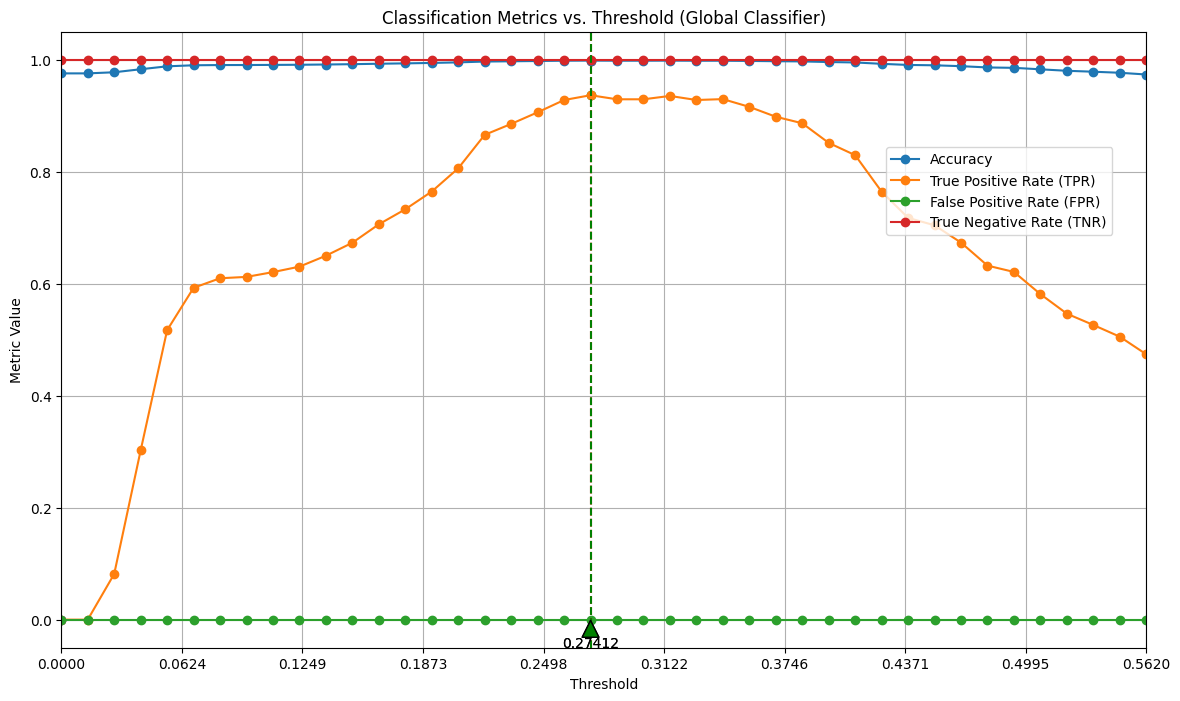

In [73]:
# Extracting data from 'fed_met' list
thresholds = [entry[0] for entry in first_round]
accuracy = [entry[1] for entry in first_round]
TPR = [entry[2] for entry in first_round]
FPR = [entry[3] for entry in first_round]
TNR = [entry[4] for entry in first_round]

# Find the best thresholds
best_accuracy_idx = np.argmax(accuracy)
best_tpr_idx = np.argmax(TPR)
best_fpr_idx = np.argmin(FPR)

best_accuracy_threshold = thresholds[best_accuracy_idx]
best_tpr_threshold = thresholds[best_tpr_idx]
best_fpr_threshold = thresholds[best_fpr_idx]

# Plotting
plt.figure(figsize=(14, 8))

# Accuracy
plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
plt.scatter(best_accuracy_threshold, accuracy[best_accuracy_idx], color='red')  # Highlight best accuracy

# True Positive Rate (TPR)
plt.plot(thresholds, TPR, label='True Positive Rate (TPR)', marker='o')
plt.scatter(best_tpr_threshold, TPR[best_tpr_idx], color='green')  # Highlight best TPR

# False Positive Rate (FPR)
plt.plot(thresholds, FPR, label='False Positive Rate (FPR)', marker='o')
plt.scatter(best_fpr_threshold, FPR[best_fpr_idx], color='blue')  # Highlight best (lowest) FPR
# True Negative Rate (TNR)
plt.plot(thresholds, TNR, label='True Negative Rate (TNR)', marker='o')

# Adjusting x-axis scale
plt.xlim(min(thresholds), max(thresholds))
plt.xticks(np.linspace(min(thresholds), max(thresholds), num=10))

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Classification Metrics vs. Threshold (Global Classifier)')
plt.legend(loc=(0.76, 0.67))
plt.grid(True)

# Add vertical dashed lines and annotate the x-axis
plt.axvline(x=best_accuracy_threshold, color='red', linestyle='--')
plt.annotate(f'{best_accuracy_threshold:.5f}', xy=(best_accuracy_threshold, 0), xytext=(best_accuracy_threshold, -0.05),
             arrowprops=dict(facecolor='red', shrink=0.05), horizontalalignment='center')

plt.axvline(x=best_tpr_threshold, color='green', linestyle='--')
plt.annotate(f'{best_tpr_threshold:.5f}', xy=(best_tpr_threshold, 0), xytext=(best_tpr_threshold, -0.05),
             arrowprops=dict(facecolor='green', shrink=0.05), horizontalalignment='center')

"""# Add a text box with the best values
textstr = '\n'.join((
    f'Best Accuracy: {accuracy[best_accuracy_idx]:.5f} at threshold {best_accuracy_threshold}',
    f'Best TPR: {TPR[best_tpr_idx]:.5f} at threshold {best_tpr_threshold}',
))

# Place a text box to the right of the plot
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gcf().text(0.95, 0.5, textstr, fontsize=12, verticalalignment='center', bbox=props)

plt.show()"""
print(f'\nBest Accuracy: {accuracy[best_accuracy_idx]:.5f} at threshold {best_accuracy_threshold}',
    f'\nBest TPR: {TPR[best_tpr_idx]:.5f} at threshold {best_tpr_threshold}\n') 

In [401]:
from collections import Counter
c=Counter(mixed_data_labels)
c

Counter({'Common Cold': 20,
         'Impetigo': 20,
         'Heart attack': 20,
         'Hepatitis D': 20,
         'Hyperthyroidism': 20,
         'Hypothyroidism': 20,
         'Alcoholic hepatitis': 20,
         'Migraine': 20,
         'Hepatitis B': 20,
         '(vertigo) Paroymsal  Positional Vertigo': 20,
         'Dengue': 20,
         'Urinary tract infection': 20,
         'Dimorphic hemmorhoids(piles)': 20,
         'Bronchial Asthma': 20,
         'Arthritis': 20,
         'Malaria': 20,
         'AIDS': 20,
         'Cervical spondylosis': 20,
         'Pneumonia': 20,
         'Chronic cholestasis': 20,
         'Allergy': 20,
         'Jaundice': 20,
         'GERD': 20,
         'Paralysis (brain hemorrhage)': 20,
         'Peptic ulcer diseae': 20,
         'hepatitis A': 20,
         'Typhoid': 20,
         'Fungal infection': 20,
         'Diabetes': 20,
         'Hypertension': 20,
         'Acne': 20,
         'Chicken pox': 20,
         'Osteoarthristis': 20,


In [74]:
import os
from joblib import dump

# Define the directory path
directory = '/kaggle/working/models_fixed_overfit'

# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the kmeans model
dump(kmeans, '/kaggle/working/models_fixed_overfit/kmeans_model.joblib')


['/kaggle/working/models_fixed_overfit/kmeans_model.joblib']

In [75]:
labels_to_remove=[]
for i in new:
    if i[:-2] in old and i[:-2] not in labels_to_remove:
        labels_to_remove.append(i[:-2])
labels_to_remove

['Dimorphic hemmorhoids(piles)',
 'Arthritis',
 'Acne',
 'Urinary tract infection',
 'Peptic ulcer diseae',
 'Gastroenteritis',
 'Varicose veins',
 'Hypothyroidism',
 'Diabetes',
 'Paralysis (brain hemorrhage)',
 'hepatitis A',
 'Dengue',
 'Bronchial Asthma',
 'Psoriasis',
 'Heart attack',
 'Drug Reaction',
 'Hepatitis C',
 'Hepatitis B',
 '(vertigo) Paroymsal  Positional Vertigo',
 'Hypoglycemia',
 'Hypertension',
 'Alcoholic hepatitis',
 'Hyperthyroidism',
 'Hepatitis D',
 'GERD',
 'Common Cold',
 'Osteoarthristis',
 'Cervical spondylosis',
 'Migraine',
 'Tuberculosis',
 'Hepatitis E',
 'AIDS',
 'Jaundice',
 'Fungal infection',
 'Impetigo',
 'Pneumonia',
 'Malaria',
 'Allergy',
 'Chronic cholestasis',
 'Typhoid',
 'Chicken pox']

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

input_dim = train_loader['Arthritis'].dataset.shape[1]

# Define AEModel with regularization
class AEModelEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AEModelEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 120)  
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 15)
        self.fc6 = nn.Linear(15, 15)
        self.activation = nn.Tanh()
        #self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.5
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        #x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        #x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        return x
    
    
# Function to load encoder weights from the full model
def load_encoder_weights(full_model, encoder_model):
    encoder_model.fc1.weight.data = full_model.fc1.weight.data
    encoder_model.fc1.bias.data = full_model.fc1.bias.data
    encoder_model.fc2.weight.data = full_model.fc2.weight.data
    encoder_model.fc2.bias.data = full_model.fc2.bias.data
    encoder_model.fc3.weight.data = full_model.fc3.weight.data
    encoder_model.fc3.bias.data = full_model.fc3.bias.data
    encoder_model.fc4.weight.data = full_model.fc4.weight.data
    encoder_model.fc4.bias.data = full_model.fc4.bias.data
    encoder_model.fc5.weight.data = full_model.fc5.weight.data
    encoder_model.fc5.bias.data = full_model.fc5.bias.data
    encoder_model.fc6.weight.data = full_model.fc6.weight.data
    encoder_model.fc6.bias.data = full_model.fc6.bias.data
# Update client_models to use the encoder-only model
extra_clients = {}
for device in devices:
    if device[:-2] in devices or device in labels_to_remove:
        full_model = torch.load('/kaggle/input/dieseases/keras/aggregated/3/clients/' + device + '.pt')
        encoder_model = AEModelEncoder(input_dim)
        load_encoder_weights(full_model, encoder_model)
        extra_clients[device] = encoder_model
extra_clients.keys()

dict_keys(['Dimorphic hemmorhoids(piles)', 'Arthritis', 'Acne', 'Urinary tract infection', 'Peptic ulcer diseae', 'Gastroenteritis', 'Varicose veins', 'Hypothyroidism', 'Diabetes', 'Paralysis (brain hemorrhage)', 'hepatitis A', 'Dengue', 'Bronchial Asthma', 'Psoriasis', 'Heart attack', 'Drug Reaction', 'Hepatitis C', 'Hepatitis B', '(vertigo) Paroymsal  Positional Vertigo', 'Hypoglycemia', 'Hypertension', 'Alcoholic hepatitis', 'Hyperthyroidism', 'Hepatitis D', 'GERD', 'Common Cold', 'Osteoarthristis', 'Cervical spondylosis', 'Migraine', 'Tuberculosis', 'Hepatitis E', 'AIDS', 'Jaundice', 'Fungal infection', 'Impetigo', 'Pneumonia', 'Malaria', 'Allergy', 'Chronic cholestasis', 'Typhoid', 'Chicken pox', 'Dimorphic hemmorhoids(piles)-1', 'Arthritis-1', 'Acne-1', 'Urinary tract infection-1', 'Peptic ulcer diseae-1', 'Gastroenteritis-1', 'Varicose veins-1', 'Hypothyroidism-1', 'Diabetes-1', 'Paralysis (brain hemorrhage)-1', 'hepatitis A-1', 'Dengue-1', 'Bronchial Asthma-1', 'Psoriasis-1', '

In [94]:
len(extra_clients.keys())

82

In [95]:
extra_compressed_outs = {}
extra_compressed_outs_test = {}
for i in extra_clients:
    model = extra_clients[i]
    model.eval()
    dataloader = train_loader[i]
    outs = []
    ind = 0
    flag = False
    for batch in dataloader:
        for data in batch:
            layer_output = model(data.float()).detach().numpy()
            outs.append(layer_output)
            ind += 1
            if ind == 60:
                extra_compressed_outs[i] = outs
                outs = []
            elif i[:-2] in extra_clients and ind==40:
                extra_compressed_outs[i] = outs
                outs = []
            elif ind == 70:
                extra_compressed_outs_test[i] = outs
                flag = True
                break
        if flag:
            break

In [96]:
for i in extra_compressed_outs:
    if i[:-2] in extra_compressed_outs:
        for j in extra_compressed_outs[i]:
            extra_compressed_outs[i[:-2]].append(j)

In [97]:
l=[]
for i in extra_compressed_outs:
    if i[-2]=="-":
        l.append(i)
for i in l:
    extra_compressed_outs.pop(i)

In [98]:
for i in extra_compressed_outs.keys():
    print(i,': ',len(extra_compressed_outs[i]))


Dimorphic hemmorhoids(piles) :  100
Arthritis :  100
Acne :  100
Urinary tract infection :  100
Peptic ulcer diseae :  100
Gastroenteritis :  100
Varicose veins :  100
Hypothyroidism :  100
Diabetes :  100
Paralysis (brain hemorrhage) :  100
hepatitis A :  100
Dengue :  100
Bronchial Asthma :  100
Psoriasis :  100
Heart attack :  100
Drug Reaction :  100
Hepatitis C :  100
Hepatitis B :  100
(vertigo) Paroymsal  Positional Vertigo :  100
Hypoglycemia :  100
Hypertension :  100
Alcoholic hepatitis :  100
Hyperthyroidism :  100
Hepatitis D :  100
GERD :  100
Common Cold :  100
Osteoarthristis :  100
Cervical spondylosis :  100
Migraine :  100
Tuberculosis :  100
Hepatitis E :  100
AIDS :  100
Jaundice :  100
Fungal infection :  100
Impetigo :  100
Pneumonia :  100
Malaria :  100
Allergy :  100
Chronic cholestasis :  100
Typhoid :  100
Chicken pox :  100


In [99]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np

# Extract data from the dictionary
data_new = []
labels_new = []

for label, tensors in extra_compressed_outs.items():
    for tensor in tensors:
        data_new.append(tensor)
        labels_new.append(label)

data_new = np.array(data_new)
labels_new = np.array(labels_new)

# Get the number of samples
num_samples = len(data_new)

# Generate a random permutation of indices
permutation_indices = np.random.permutation(num_samples)

# Shuffle data and labels arrays using the permutation
shuffled_data = data_new[permutation_indices]
shuffled_labels = labels_new[permutation_indices]
data_new=shuffled_data
labels_new=shuffled_labels

In [100]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming you have the trained KMeans model stored as kmeans_model
# Assuming you have the cluster labels stored in cluster_labels dictionary
# Assuming you have the labels you want to remove stored in labels_to_remove list

centroids_to_keep = []
labels_to_keep = []

# Iterate over the cluster labels
for cluster, label in cluster_labels.items():
    # Check if the label is not in labels_to_remove
    if label not in labels_to_remove:
        # Append the cluster centroid and label for clusters to keep
        centroids_to_keep.append(kmeans.cluster_centers_[cluster])
        labels_to_keep.append(label)

# Convert the lists to numpy arrays
centroids_to_keep = np.array(centroids_to_keep)
labels_to_keep = np.array(labels_to_keep)

In [101]:
print(len(centroids_to_keep))
print(n)
print(n-len(centroids_to_keep))

0
42
42


In [102]:
# Store the previous centroids
previous_centroids = centroids_to_keep

# Calculate the total number of clusters for the new model
new_n_clusters = n-len(centroids_to_keep)

# Create a new KMeans model with the desired number of clusters
new_kmeans = KMeans(n_clusters=new_n_clusters, random_state=100)
new_kmeans.fit(data_new)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=42, random_state=100)

In [103]:
cluster_labels = new_kmeans.predict(data_new)
# Dictionary to store attacks and their counts for each cluster
cluster_attacks_count = {cluster: {} for cluster in range(len(new_kmeans.cluster_centers_))}

# Iterate through data and cluster labels
for idx, cluster_label in enumerate(cluster_labels):
    attack = labels_new[idx]
    if attack not in cluster_attacks_count[cluster_label]:
        cluster_attacks_count[cluster_label][attack] = 1
        
    else:
        cluster_attacks_count[cluster_label][attack] += 1
# Print attacks and their counts for each cluster
for cluster, attack_counts in cluster_attacks_count.items():
    print(f"Cluster {cluster}: {attack_counts}")

Cluster 0: {'Hypoglycemia': 100}
Cluster 1: {'Urinary tract infection': 100}
Cluster 2: {'(vertigo) Paroymsal  Positional Vertigo': 100}
Cluster 3: {'Pneumonia': 100}
Cluster 4: {'Alcoholic hepatitis': 13}
Cluster 5: {'Psoriasis': 100}
Cluster 6: {'Dengue': 100}
Cluster 7: {'Allergy': 100}
Cluster 8: {'Hepatitis B': 100}
Cluster 9: {'Chicken pox': 100}
Cluster 10: {'GERD': 100}
Cluster 11: {'Cervical spondylosis': 100}
Cluster 12: {'Peptic ulcer diseae': 100}
Cluster 13: {'Hepatitis E': 100}
Cluster 14: {'Hepatitis D': 100}
Cluster 15: {'Bronchial Asthma': 100}
Cluster 16: {'Dimorphic hemmorhoids(piles)': 100}
Cluster 17: {'hepatitis A': 100}
Cluster 18: {'Hypertension': 100}
Cluster 19: {'Hyperthyroidism': 100}
Cluster 20: {'Fungal infection': 100}
Cluster 21: {'Migraine': 100}
Cluster 22: {'Impetigo': 100}
Cluster 23: {'Chronic cholestasis': 100}
Cluster 24: {'Paralysis (brain hemorrhage)': 100}
Cluster 25: {'Diabetes': 100}
Cluster 26: {'Acne': 100}
Cluster 27: {'Malaria': 100}
Clus

In [104]:
for cluster, attack_counts in cluster_attacks_count.items():
    if cluster<len(labels_to_keep):
        cluster_attacks_count[cluster]={labels_to_keep[cluster] : 1}
cluster_attacks_count

{0: {'Hypoglycemia': 100},
 1: {'Urinary tract infection': 100},
 2: {'(vertigo) Paroymsal  Positional Vertigo': 100},
 3: {'Pneumonia': 100},
 4: {'Alcoholic hepatitis': 13},
 5: {'Psoriasis': 100},
 6: {'Dengue': 100},
 7: {'Allergy': 100},
 8: {'Hepatitis B': 100},
 9: {'Chicken pox': 100},
 10: {'GERD': 100},
 11: {'Cervical spondylosis': 100},
 12: {'Peptic ulcer diseae': 100},
 13: {'Hepatitis E': 100},
 14: {'Hepatitis D': 100},
 15: {'Bronchial Asthma': 100},
 16: {'Dimorphic hemmorhoids(piles)': 100},
 17: {'hepatitis A': 100},
 18: {'Hypertension': 100},
 19: {'Hyperthyroidism': 100},
 20: {'Fungal infection': 100},
 21: {'Migraine': 100},
 22: {'Impetigo': 100},
 23: {'Chronic cholestasis': 100},
 24: {'Paralysis (brain hemorrhage)': 100},
 25: {'Diabetes': 100},
 26: {'Acne': 100},
 27: {'Malaria': 100},
 28: {'Typhoid': 100},
 29: {'Common Cold': 100},
 30: {'Gastroenteritis': 100},
 31: {'Drug Reaction': 100},
 32: {'AIDS': 100},
 33: {'Heart attack': 100},
 34: {'Jaundic

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

input_dim = train_loader['Arthritis'].dataset.shape[1]

# Define AEModel with regularization
class AEModelEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AEModelEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 120)  
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 15)
        self.fc6 = nn.Linear(15, 15)
        self.activation = nn.Tanh()
        #self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.5
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        #x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        #x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        return x
    
    
# Function to load encoder weights from the full model
def load_encoder_weights(full_model, encoder_model):
    encoder_model.fc1.weight.data = full_model.fc1.weight.data
    encoder_model.fc1.bias.data = full_model.fc1.bias.data
    encoder_model.fc2.weight.data = full_model.fc2.weight.data
    encoder_model.fc2.bias.data = full_model.fc2.bias.data
    encoder_model.fc3.weight.data = full_model.fc3.weight.data
    encoder_model.fc3.bias.data = full_model.fc3.bias.data
    encoder_model.fc4.weight.data = full_model.fc4.weight.data
    encoder_model.fc4.bias.data = full_model.fc4.bias.data
    encoder_model.fc5.weight.data = full_model.fc5.weight.data
    encoder_model.fc5.bias.data = full_model.fc5.bias.data
    encoder_model.fc6.weight.data = full_model.fc6.weight.data
    encoder_model.fc6.bias.data = full_model.fc6.bias.data
# Update client_models to use the encoder-only model
client_models = {}
for device in devices:
    full_model = torch.load('/kaggle/input/dieseases/keras/aggregated/3/clients/' + device + '.pt')
    encoder_model = AEModelEncoder(input_dim)
    load_encoder_weights(full_model, encoder_model)
    client_models[device] = encoder_model
client_models.keys()

dict_keys(['Dimorphic hemmorhoids(piles)', 'Arthritis', 'Acne', 'Urinary tract infection', 'Peptic ulcer diseae', 'Gastroenteritis', 'Varicose veins', 'Hypothyroidism', 'Diabetes', 'Paralysis (brain hemorrhage)', 'hepatitis A', 'Dengue', 'Bronchial Asthma', 'Psoriasis', 'Heart attack', 'Drug Reaction', 'Hepatitis C', 'Hepatitis B', '(vertigo) Paroymsal  Positional Vertigo', 'Hypoglycemia', 'Hypertension', 'Alcoholic hepatitis', 'Hyperthyroidism', 'Hepatitis D', 'GERD', 'Common Cold', 'Osteoarthristis', 'Cervical spondylosis', 'Migraine', 'Tuberculosis', 'Hepatitis E', 'AIDS', 'Jaundice', 'Fungal infection', 'Impetigo', 'Pneumonia', 'Malaria', 'Allergy', 'Chronic cholestasis', 'Typhoid', 'Chicken pox', 'Dimorphic hemmorhoids(piles)-1', 'Arthritis-1', 'Acne-1', 'Urinary tract infection-1', 'Peptic ulcer diseae-1', 'Gastroenteritis-1', 'Varicose veins-1', 'Hypothyroidism-1', 'Diabetes-1', 'Paralysis (brain hemorrhage)-1', 'hepatitis A-1', 'Dengue-1', 'Bronchial Asthma-1', 'Psoriasis-1', '

In [106]:
cluster_labels = {}
for i in range(len(cluster_attacks_count)):
    cluster_labels[i] = max(cluster_attacks_count[i], key=cluster_attacks_count[i].get)
cluster_labels

{0: 'Hypoglycemia',
 1: 'Urinary tract infection',
 2: '(vertigo) Paroymsal  Positional Vertigo',
 3: 'Pneumonia',
 4: 'Alcoholic hepatitis',
 5: 'Psoriasis',
 6: 'Dengue',
 7: 'Allergy',
 8: 'Hepatitis B',
 9: 'Chicken pox',
 10: 'GERD',
 11: 'Cervical spondylosis',
 12: 'Peptic ulcer diseae',
 13: 'Hepatitis E',
 14: 'Hepatitis D',
 15: 'Bronchial Asthma',
 16: 'Dimorphic hemmorhoids(piles)',
 17: 'hepatitis A',
 18: 'Hypertension',
 19: 'Hyperthyroidism',
 20: 'Fungal infection',
 21: 'Migraine',
 22: 'Impetigo',
 23: 'Chronic cholestasis',
 24: 'Paralysis (brain hemorrhage)',
 25: 'Diabetes',
 26: 'Acne',
 27: 'Malaria',
 28: 'Typhoid',
 29: 'Common Cold',
 30: 'Gastroenteritis',
 31: 'Drug Reaction',
 32: 'AIDS',
 33: 'Heart attack',
 34: 'Jaundice',
 35: 'Hepatitis C',
 36: 'Varicose veins',
 37: 'Tuberculosis',
 38: 'Osteoarthristis',
 39: 'Arthritis',
 40: 'Hypothyroidism',
 41: 'Alcoholic hepatitis'}

In [107]:
cluster_labels={0: 'Hypoglycemia',
 1: 'Urinary tract infection',
 2: '(vertigo) Paroymsal  Positional Vertigo',
 3: 'Pneumonia',
 4: 'Alcoholic hepatitis',
 5: 'Psoriasis',
 6: 'Dengue',
 7: 'Allergy',
 8: 'Hepatitis B',
 9: 'Chicken pox',
 10: 'GERD',
 11: 'Cervical spondylosis',
 12: 'Peptic ulcer diseae',
 13: 'Hepatitis E',
 14: 'Hepatitis D',
 15: 'Bronchial Asthma',
 16: 'Dimorphic hemmorhoids(piles)',
 17: 'hepatitis A',
 18: 'Hypertension',
 19: 'Hyperthyroidism',
 20: 'Fungal infection',
 21: 'Migraine',
 22: 'Impetigo',
 23: 'Chronic cholestasis',
 24: 'Paralysis (brain hemorrhage)',
 25: 'Diabetes',
 26: 'Acne',
 27: 'Malaria',
 28: 'Typhoid',
 29: 'Common Cold',
 30: 'Gastroenteritis',
 31: 'Drug Reaction',
 32: 'AIDS',
 33: 'Heart attack',
 34: 'Jaundice',
 35: 'Hepatitis C',
 36: 'Varicose veins',
 37: 'Tuberculosis',
 38: 'Osteoarthristis',
 39: 'Arthritis',
 40: 'Hypothyroidism',
 41: 'Alcoholic hepatitis'}

In [108]:
compressed_mixed = {}
for data in mixed_data:
    for i in client_models:
        model = client_models[i]
        model.eval()
        layer_output = model(torch.Tensor(data))
        try:
            compressed_mixed[i].append(layer_output)
        except:
            compressed_mixed[i] = [layer_output]

In [109]:
def classify_new_data_fed(new_data_point, threshold):
    # Predict the cluster for the new data point
    new_data_cluster = new_kmeans.predict(np.array(new_data_point))
    # Get the centroid of the predicted cluster
    centroid = new_kmeans.cluster_centers_[new_data_cluster]
    # Calculate the Euclidean distance between the new data point and the centroid
    distance = np.sqrt(np.sum((new_data_point - centroid) ** 2))
    # Classify based on the distance
    if distance < threshold:
        return new_data_cluster[0]
    else:
        return False


num_encoders=41
num_clusters=42
num_clients=82
fed_met=[]
start = 0
end =  min(old_thresholds.values())
step = end/num_clusters
i = start
first_fed_round=[]
prev_TPR=0

for x in range(num_clients):
    fed_met=[]
    print("Round :"+str(x+1))
    while i < end:
        print(i,TPR)
        TP,FP,TN,FN = 0,0,0,0
        # Iterate through the compressed_mixed dictionary and classify each data point
        for model, data_list in compressed_mixed.items():
            j = 0
            for data in data_list:
                # Convert the data to NumPy array and detach from computation graph
                data_np = data.detach().numpy()
                data_np = data_np.reshape(1,-1)
                # Convert the data to double data type before passing it to KMeans model
                if classify_new_data_fed(data_np, i) == False:
                    classification_result = False
                else: 
                    classification_result = cluster_labels[classify_new_data_fed(data_np, i)]
                if classification_result == False:
                    if model == mixed_data_labels[j]:
                        FN += 1
                    else:
                        TN += 1
                else:
                    if classification_result == mixed_data_labels[j]:
                        if model == mixed_data_labels[j]:
                            TP += 1
                        else:
                            FP += 1
                    else:
                        FN += 1
                j += 1

        if TP==0:
            TP=0.1

        #print(i)
        # Calculate accuracy
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        # Calculate true positive rate (TPR) or sensitivity or recall
        TPR = TP / (TP + FN)

        # Calculate false positive rate (FPR)
        FPR = FP / (FP + TN)

        # Calculate specificity or true negative rate (TNR)
        TNR = TN / (FP + TN)

        # Calculate precision or positive predictive value (PPV)
        PPV = TP / (TP + FP)

        fed_met.append([i,accuracy,TPR,FPR,TNR])
        if x==0:
            first_fed_round.append([i,accuracy,TPR,FPR,TNR])
        i += step
    print(fed_met)
    # Extracting data from 'fed_met' list
    thresholds = [entry[0] for entry in fed_met]
    TPR = [entry[2] for entry in fed_met]

    # Find the best thresholds
    # best_accuracy_idx = np.argmax(accuracy)

    best_tpr_idx = np.argmax(TPR)
    best_TPR = round(TPR[best_tpr_idx], 4)
    if best_tpr_idx==0:
        start=thresholds[best_tpr_idx]
    else:
        start=thresholds[best_tpr_idx-1]
    if best_tpr_idx == len(thresholds) - 1:
        end = thresholds[best_tpr_idx]
    else:
        end = thresholds[best_tpr_idx + 1]
    step = end/num_clusters
    i=start
    if prev_TPR==best_TPR:
        break
    prev_TPR=best_TPR
    #nxt_acc_thresh = thresholds[best_accuracy_idx+1]
    #nxt_tpr_thresh = thresholds[best_tpr_idx+1]


Round :1
0 [0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00012193634922570419, 0.00

In [110]:
# Extracting data from 'fed_met' list
thresholds = [entry[0] for entry in fed_met]
accuracy = [entry[1] for entry in fed_met]
TPR = [entry[2] for entry in fed_met]
FPR = [entry[3] for entry in fed_met]
TNR = [entry[4] for entry in fed_met]

# Find the best thresholds
best_accuracy_idx = np.argmax(accuracy)
best_tpr_idx = np.argmax(TPR)
best_fpr_idx = np.argmin(FPR)

best_accuracy_threshold = thresholds[best_accuracy_idx]
best_tpr_threshold = thresholds[best_tpr_idx]
best_tpr_threshold

0.053854338892425344

In [111]:
compressed_test = {}
for data in test_data:
    for i in client_models:
        model = client_models[i]
        model.eval()
        layer_output = model(torch.Tensor(data))
        try:
            compressed_test[i].append(layer_output)
        except:
            compressed_test[i] = [layer_output]


In [ ]:
def classify_new_data_fed(new_data_point, threshold):
    # Predict the cluster for the new data point
    new_data_cluster = new_kmeans.predict(np.array(new_data_point))
    # Get the centroid of the predicted cluster
    centroid = new_kmeans.cluster_centers_[new_data_cluster]
    # Calculate the Euclidean distance between the new data point and the centroid
    distance = np.sqrt(np.sum((new_data_point - centroid) ** 2))
    # Classify based on the distance
    if distance < threshold:
        return new_data_cluster[0]
    else:
        return False

threshold = best_tpr_threshold


# Iterate through the compressed_mixed dictionary and classify each data point
for model, data_list in compressed_test.items():
    TP,FP,TN,FN = 0, 0, 0, 0
    j = 0
    for data in data_list:
        # Convert the data to NumPy array and detach from computation graph
        data_np = data.detach().numpy()
        data_np = data_np.reshape(1,-1)
        # Convert the data to double data type before passing it to KMeans model
        if classify_new_data_fed(data_np, threshold) == False:
            classification_result = False
        else: 
            classification_result = cluster_labels[classify_new_data_fed(data_np, threshold)]
        if classification_result == False:
            if model == test_data_labels[j]:
                FN += 1
            else:
                TN += 1
        else:
            if classification_result == test_data_labels[j]:
                if model == test_data_labels[j]:
                    TP += 1
                else:
                    FP += 1
            else:
                FN += 1
        j += 1
            


    print()
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Calculate true positive rate (TPR) or sensitivity or recall
    TPR = TP / (TP + FN)

    # Calculate false positive rate (FPR)
    FPR = FP / (FP + TN)

    # Calculate specificity or true negative rate (TNR)
    TNR = TN / (FP + TN)

    # Calculate precision or positive predictive value (PPV)
    PPV = TP / (TP + FP)



    # Print the metrics with up to four decimal places
    print(f"Data from :" +str(model))
    print("TP:", f"{TP}")
    print("TN:", f"{TN}")
    print("FP:", f"{FP}")
    print("FN:", f"{FN}")
    print("Accuracy:", f"{accuracy*100:.4f}")
    print("True Positive Rate (TPR):", f"{TPR:.4f}")
    print("False Positive Rate (FPR):", f"{FPR:.4f}")
    print("True Negative Rate (TNR):", f"{TNR:.4f}")
    print("Positive Predictive Value (PPV):", f"{PPV:.4f}")
    print()

In [112]:
def classify_new_data_fed(new_data_point, threshold):
    # Predict the cluster for the new data point
    new_data_cluster = new_kmeans.predict(np.array(new_data_point))
    # Get the centroid of the predicted cluster
    centroid = new_kmeans.cluster_centers_[new_data_cluster]
    # Calculate the Euclidean distance between the new data point and the centroid
    distance = np.sqrt(np.sum((new_data_point - centroid) ** 2))
    # Classify based on the distance
    if distance < threshold:
        return new_data_cluster[0]
    else:
        return False


threshold = best_tpr_threshold
TP,FP,TN,FN = 0,0,0,0

# Iterate through the compressed_mixed dictionary and classify each data point
for model, data_list in compressed_test.items():
    j = 0
    for data in data_list:
        # Convert the data to NumPy array and detach from computation graph
        data_np = data.detach().numpy()
        data_np = data_np.reshape(1,-1)
        # Convert the data to double data type before passing it to KMeans model
        if classify_new_data_fed(data_np, threshold) == False:
            classification_result = False
        else: 
            classification_result = cluster_labels[classify_new_data_fed(data_np, threshold)]
        if classification_result == False:
            if model == test_data_labels[j]:
                FN += 1
            else:
                TN += 1
        else:
            if classification_result == test_data_labels[j]:
                if model == test_data_labels[j]:
                    TP += 1
                else:
                    FP += 1
            else:
                FN += 1
        j += 1
            


print()
# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate true positive rate (TPR) or sensitivity or recall
TPR = TP / (TP + FN)

# Calculate false positive rate (FPR)
FPR = FP / (FP + TN)

# Calculate specificity or true negative rate (TNR)
TNR = TN / (FP + TN)

# Calculate precision or positive predictive value (PPV)
PPV = TP / (TP + FP)



# Print the metrics with up to four decimal places
print(f"Global Classifier :")
print("TP:", f"{TP}")
print("TN:", f"{TN}")
print("FP:", f"{FP}")
print("FN:", f"{FN}")
print("Accuracy:", f"{accuracy*100:.4f}")
print("True Positive Rate (TPR):", f"{TPR:.4f}")
print("False Positive Rate (FPR):", f"{FPR:.4f}")
print("True Negative Rate (TNR):", f"{TNR:.4f}")
print("Positive Predictive Value (PPV):", f"{PPV:.4f}")
print()


Global Classifier :
TP: 691
TN: 65721
FP: 691
FN: 137
Accuracy: 98.7686
True Positive Rate (TPR): 0.8345
False Positive Rate (FPR): 0.0104
True Negative Rate (TNR): 0.9896
Positive Predictive Value (PPV): 0.5000




Best Accuracy: 0.98780 at threshold 0 
Best TPR: 0.84058 at threshold 0.05482446734355645



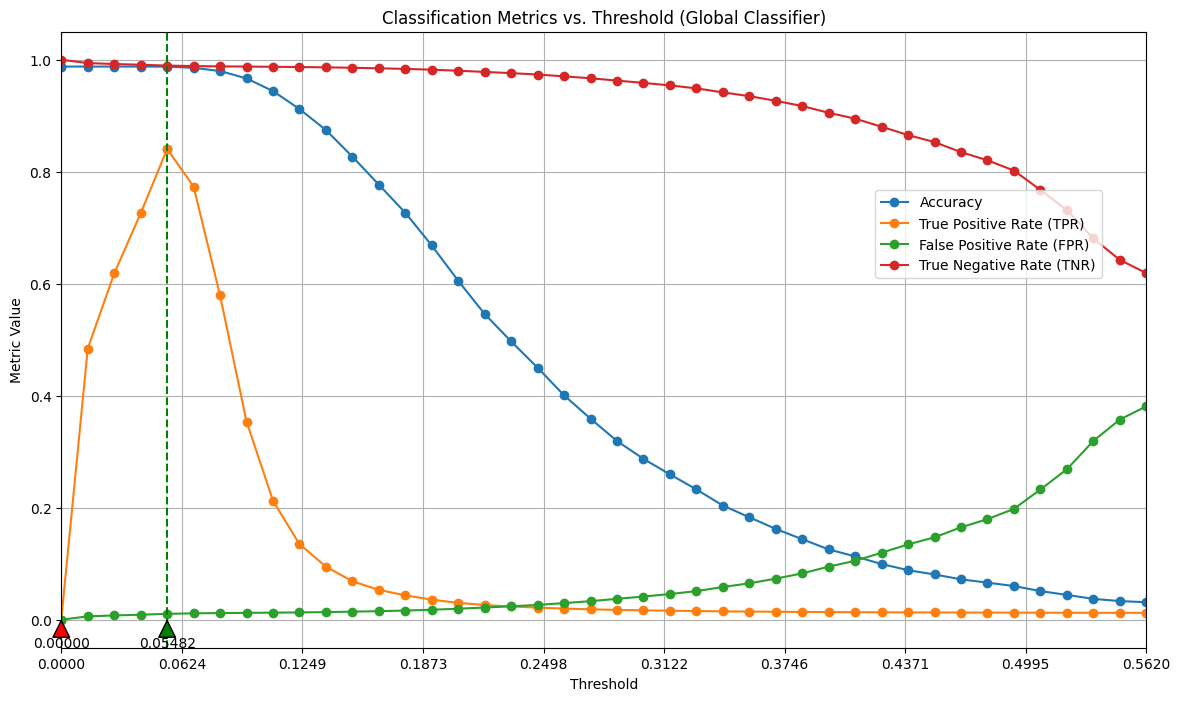

In [113]:
# Extracting data from 'fed_met' list
thresholds = [entry[0] for entry in first_fed_round]
accuracy = [entry[1] for entry in first_fed_round]
TPR = [entry[2] for entry in first_fed_round]
FPR = [entry[3] for entry in first_fed_round]
TNR = [entry[4] for entry in first_fed_round]

# Find the best thresholds
best_accuracy_idx = np.argmax(accuracy)
best_tpr_idx = np.argmax(TPR)
best_fpr_idx = np.argmin(FPR)

best_accuracy_threshold = thresholds[best_accuracy_idx]
best_tpr_threshold = thresholds[best_tpr_idx]

# Plotting
plt.figure(figsize=(14, 8))

# Accuracy
plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
plt.scatter(best_accuracy_threshold, accuracy[best_accuracy_idx], color='red')  # Highlight best accuracy

# True Positive Rate (TPR)
plt.plot(thresholds, TPR, label='True Positive Rate (TPR)', marker='o')
plt.scatter(best_tpr_threshold, TPR[best_tpr_idx], color='green')  # Highlight best TPR

# False Positive Rate (FPR)
plt.plot(thresholds, FPR, label='False Positive Rate (FPR)', marker='o')
plt.scatter(best_fpr_threshold, FPR[best_fpr_idx], color='blue')  # Highlight best (lowest) FPR
# True Negative Rate (TNR)
plt.plot(thresholds, TNR, label='True Negative Rate (TNR)', marker='o')

# Adjusting x-axis scale
plt.xlim(min(thresholds), max(thresholds))
plt.xticks(np.linspace(min(thresholds), max(thresholds), num=10))

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Classification Metrics vs. Threshold (Global Classifier)')
plt.legend(loc=(0.75, 0.6))
plt.grid(True)

# Add vertical dashed lines and annotate the x-axis
plt.axvline(x=best_accuracy_threshold, color='red', linestyle='--')
plt.annotate(f'{best_accuracy_threshold:.5f}', xy=(best_accuracy_threshold, 0), xytext=(best_accuracy_threshold, -0.05),
             arrowprops=dict(facecolor='red', shrink=0.05), horizontalalignment='center')

plt.axvline(x=best_tpr_threshold, color='green', linestyle='--')
plt.annotate(f'{best_tpr_threshold:.5f}', xy=(best_tpr_threshold, 0), xytext=(best_tpr_threshold, -0.05),
             arrowprops=dict(facecolor='green', shrink=0.05), horizontalalignment='center')

"""# Add a text box with the best values
textstr = '\n'.join((
    f'Best Accuracy: {accuracy[best_accuracy_idx]:.5f} at threshold {best_accuracy_threshold}',
    f'Best TPR: {TPR[best_tpr_idx]:.5f} at threshold {best_tpr_threshold}',
))

# Place a text box to the right of the plot
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gcf().text(0.95, 0.5, textstr, fontsize=12, verticalalignment='center', bbox=props)

plt.show()"""
print(f'\nBest Accuracy: {accuracy[best_accuracy_idx]:.5f} at threshold {best_accuracy_threshold}',
    f'\nBest TPR: {TPR[best_tpr_idx]:.5f} at threshold {best_tpr_threshold}\n') 

In [114]:
dump(new_kmeans, '/kaggle/working/models_fixed_overfit/fed_kmeans_model.joblib')

['/kaggle/working/models_fixed_overfit/fed_kmeans_model.joblib']